## 7. Prediction the price of Guizhou Maotai

### 7.1 SVM

In [184]:
from datetime import datetime, timedelta
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import math, datetime
import time
import arrow
from sklearn import preprocessing,model_selection,svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import pickle

In [185]:
# Get the stock quote
df_all = pd.read_csv('stockdata_adj.csv')

# Choose Maotai from all stocks
df_all = df_all[df_all['ts_code'] == '600519.SH']

# sort the data and set the date as index
df_all.sort_values('trade_date', inplace=True)
df_all.set_index('trade_date', inplace=True)

df=df_all[['adj_open','adj_high','adj_low','adj_close','adj_volume']]
df.head()

,adj_open,adj_high,adj_low,adj_close,adj_volume
trade_date,,,,,
2014-09-22,984.34875,984.34875,960.6450,961.25750,6072.088163
2014-09-23,959.78750,964.68750,957.7050,964.56500,5640.181224
2014-09-24,958.50125,983.06250,953.0500,981.16375,7093.707755
2014-09-25,985.63500,1004.37750,985.5125,993.41375,9281.867755
2014-09-26,989.18750,999.11000,975.1000,994.14875,3708.840816


In [186]:
# Calculating percent volatility
df.loc[:, 'HIGHLOW_PCT'] = (df['adj_high'] - df['adj_close']) / df['adj_close'] * 100

# Calculating some factors
import ta
df.loc[:, 'PCT_Change'] = (df['adj_close'] - df['adj_open']) / df['adj_open'] * 100
df.loc[:, 'PCT_Change_overnight'] = df["adj_close"].pct_change()
df.loc[:, "MA5"] = df["adj_close"].rolling(window=5).mean()
df.loc[:, "STD5"] = df["adj_close"].rolling(window=5).std()


# Add momentum indicators

# ta.momentum.AwesomeOscillatorIndicator
from ta.momentum import AwesomeOscillatorIndicator
indicator_ao = AwesomeOscillatorIndicator(high=df["adj_high"], low=df["adj_low"], window1=5, window2=34)
df.loc[:, 'ao'] = indicator_ao.awesome_oscillator()

# ta.momentum.KAMAIndicato
from ta.momentum import KAMAIndicator
indicator_kama = KAMAIndicator(close=df["adj_close"], window=10, pow1=2, pow2=30)
df.loc[:, 'kama'] = indicator_kama.kama()

# ta.momentum.PercentagePriceOscillator
from ta.momentum import PercentagePriceOscillator
indicator_ppo = PercentagePriceOscillator(close=df["adj_close"], window_slow=26, window_fast=12, window_sign=9)
df.loc[:, 'ppo'] = indicator_ppo.ppo()

# ta.momentum.PercentageVolumeOscillator
from ta.momentum import PercentageVolumeOscillator
indicator_pvo = PercentageVolumeOscillator(volume=df["adj_volume"], window_slow=26, window_fast=12, window_sign=9)
df.loc[:, 'pvo'] = indicator_pvo.pvo()

# ta.momentum.ROCIndicator
from ta.momentum import ROCIndicator
indicator_roc = ROCIndicator(close=df["adj_close"], window=12)
df.loc[:, 'roc'] = indicator_roc.roc()

# ta.momentum.RSIIndicator
from ta.momentum import RSIIndicator
indicator_rsi = RSIIndicator(close=df["adj_close"], window=14)
df.loc[:, 'rsi'] = indicator_rsi.rsi()

# ta.momentum.StochRSIIndicator
from ta.momentum import StochRSIIndicator
indicator_stochrsi = StochRSIIndicator(close=df["adj_close"], window=14, smooth1=3, smooth2=3)
df.loc[:, 'stochrsi'] = indicator_stochrsi.stochrsi()

# ta.momentum.StochasticOscillator
from ta.momentum import StochasticOscillator
indicator_stoch = StochasticOscillator(high=df["adj_high"], low=df["adj_low"], close=df["adj_close"], window=14, smooth_window=3)
df.loc[:, 'stoch'] = indicator_stoch.stoch()

# ta.momentum.TSIIndicator
from ta.momentum import TSIIndicator
indicator_tsi = TSIIndicator(close=df["adj_close"], window_slow=25, window_fast=13)
df.loc[:, 'tsi'] = indicator_tsi.tsi()

# ta.momentum.UltimateOscillator
from ta.momentum import UltimateOscillator
indicator_uo = UltimateOscillator(high=df["adj_high"], low=df["adj_low"], close=df["adj_close"], window1=7, window2=14, window3=28, weight1=4.0, weight2=2.0, weight3=1.0, fillna=True)
df.loc[:, 'uo'] = indicator_uo.ultimate_oscillator()

# ta.momentum.WilliamsRIndicator
from ta.momentum import WilliamsRIndicator
indicator_wr = WilliamsRIndicator(high=df["adj_high"], low=df["adj_low"], close=df["adj_close"], lbp=14)
df.loc[:, 'wr'] = indicator_wr.williams_r()


# Add volume indicators

# ta.volume.AccDistIndexIndicator
from ta.volume import AccDistIndexIndicator
indicator_adi = AccDistIndexIndicator(high=df["adj_high"], low=df["adj_low"], close=df["adj_close"], volume=df["adj_volume"])
df.loc[:, 'adi'] = indicator_adi.acc_dist_index()

# ta.volume.ChaikinMoneyFlowIndicator
from ta.volume import ChaikinMoneyFlowIndicator
indicator_cmf = ChaikinMoneyFlowIndicator(high=df["adj_high"], low=df["adj_low"], close=df["adj_close"], volume=df["adj_volume"], window=20, fillna=True)
df.loc[:, 'cmf'] = indicator_cmf.chaikin_money_flow()

# ta.volume.EaseOfMovementIndicator
from ta.volume import EaseOfMovementIndicator
indicator_eom = EaseOfMovementIndicator(high=df["adj_high"], low=df["adj_low"], volume=df["adj_volume"], window=14, fillna=True)
df.loc[:, 'eom'] = indicator_eom.ease_of_movement()

# ta.volume.ForceIndexIndicator
from ta.volume import ForceIndexIndicator
indicator_fi = ForceIndexIndicator(close=df["adj_close"], volume=df["adj_volume"], window=13, fillna=True)
df.loc[:, 'fi'] = indicator_fi.force_index()

# ta.volume.MFIIndicator
from ta.volume import MFIIndicator
indicator_mfi = MFIIndicator(high=df["adj_high"], low=df["adj_low"], close=df["adj_close"], volume=df["adj_volume"], window=14, fillna=True)
df.loc[:, 'mfi'] = indicator_mfi.money_flow_index()

# ta.volume.NegativeVolumeIndexIndicator
from ta.volume import NegativeVolumeIndexIndicator
indicator_nvi = NegativeVolumeIndexIndicator(close=df["adj_close"], volume=df["adj_volume"], fillna=True)
df.loc[:, 'nvi'] = indicator_nvi.negative_volume_index()

# ta.volume.OnBalanceVolumeIndicator
from ta.volume import OnBalanceVolumeIndicator
indicator_obv = OnBalanceVolumeIndicator(close=df["adj_close"], volume=df["adj_volume"], fillna=True)
df.loc[:, 'obv'] = indicator_obv.on_balance_volume()

# ta.volume.VolumePriceTrendIndicator
from ta.volume import VolumePriceTrendIndicator
indicator_vpt = VolumePriceTrendIndicator(close=df["adj_close"], volume=df["adj_volume"], fillna=True)
df.loc[:, 'vpt'] = indicator_vpt.volume_price_trend()

# ta.volume.VolumeWeightedAveragePrice
from ta.volume import VolumeWeightedAveragePrice
indicator_vwap = VolumeWeightedAveragePrice(high=df["adj_high"], low=df["adj_low"], close=df["adj_close"], volume=df["adj_volume"], window=14, fillna=True)
df.loc[:, 'vwap'] = indicator_vwap.volume_weighted_average_price()

# Add Volatility Indicators

# ta.volatility.AverageTrueRange
from ta.volatility import AverageTrueRange
indicator_atr = AverageTrueRange(high=df["adj_high"], low=df["adj_low"], close=df["adj_close"], window=14, fillna=True)
df.loc[:, 'atr'] = indicator_atr.average_true_range()

# ta.volatility.BollingerBands
from ta.volatility import BollingerBands
indicator_bb = BollingerBands(close=df["adj_close"], window=20, window_dev=2)
df.loc[:, 'bb_bbm'] = indicator_bb.bollinger_mavg()
df.loc[:, 'bb_bbh'] = indicator_bb.bollinger_hband()
df.loc[:, 'bb_bbl'] = indicator_bb.bollinger_lband()
df.loc[:, 'bb_bbhi'] = indicator_bb.bollinger_hband_indicator()
df.loc[:, 'bb_bbli'] = indicator_bb.bollinger_lband_indicator()

# ta.volatility.DonchianChannel
from ta.volatility import DonchianChannel
indicator_dc = DonchianChannel(high=df["adj_high"], low=df["adj_low"], close=df["adj_close"], window=20, fillna=True)
df.loc[:, 'dc_hband'] = indicator_dc.donchian_channel_hband()
df.loc[:, 'dc_lband'] = indicator_dc.donchian_channel_lband()

# ta.volatility.KeltnerChannel
from ta.volatility import KeltnerChannel
indicator_kc = KeltnerChannel(high=df["adj_high"], low=df["adj_low"], close=df["adj_close"], window=20, window_atr=10, fillna=True)
df.loc[:, 'kc_hband'] = indicator_kc.keltner_channel_hband()
df.loc[:, 'kc_lband'] = indicator_kc.keltner_channel_lband()
df.loc[:, 'kc_hband_ind'] = indicator_kc.keltner_channel_hband_indicator()
df.loc[:, 'kc_lband_ind'] = indicator_kc.keltner_channel_lband_indicator()

# ta.volatility.UlcerIndex
from ta.volatility import UlcerIndex
indicator_ui = UlcerIndex(close=df["adj_close"], window=14)
df.loc[:, 'ui'] = indicator_ui.ulcer_index()

# Add trend indicators

# ta.trend.ADXIndicator
from ta.trend import ADXIndicator
indicator_adx = ADXIndicator(high=df["adj_high"], low=df["adj_low"], close=df["adj_close"], window=14, fillna=True)
df.loc[:, 'adx'] = indicator_adx.adx()
df.loc[:, 'adx_pos'] = indicator_adx.adx_pos()

# ta.trend.AroonIndicator
from ta.trend import AroonIndicator
indicator_aroon = AroonIndicator(high=df["adj_high"], low=df["adj_low"], window=25, fillna=True)
df.loc[:, 'aroon_down'] = indicator_aroon.aroon_down()
df.loc[:, 'aroon_ind'] = indicator_aroon.aroon_indicator()
df.loc[:, 'aroon_up'] = indicator_aroon.aroon_up()

# ta.trend.DPOIndicator
from ta.trend import DPOIndicator
indicator_dpo = DPOIndicator(close=df["adj_close"], window=20, fillna=True)
df.loc[:, 'dpo'] = indicator_dpo.dpo()

# ta.trend.EMAIndicator
from ta.trend import EMAIndicator
indicator_ema = EMAIndicator(close=df["adj_close"], window=12, fillna=True)
df.loc[:, 'ema'] = indicator_ema.ema_indicator()

# ta.trend.IchimokuIndicator
from ta.trend import IchimokuIndicator
indicator_ichimoku = IchimokuIndicator(high=df["adj_high"], low=df["adj_low"], window1=9, window2=26, window3=52, visual=False, fillna=True)
df.loc[:, 'ichimoku_a'] = indicator_ichimoku.ichimoku_a()
df.loc[:, 'ichimoku_b'] = indicator_ichimoku.ichimoku_b()
df.loc[:, 'ichimoku_base'] = indicator_ichimoku.ichimoku_base_line()
df.loc[:, 'ichimoku_conversion'] = indicator_ichimoku.ichimoku_conversion_line()

# ta.trend.KSTIndicator
from ta.trend import KSTIndicator
indicator_kst = KSTIndicator(close=df["adj_close"], roc1=10, roc2=15, roc3=20, roc4=30, nsig=9, fillna=True)
df.loc[:, 'kst'] = indicator_kst.kst()
df.loc[:, 'kst_diff'] = indicator_kst.kst_diff()
df.loc[:, 'kst_sig'] = indicator_kst.kst_sig()

# ta.trend.MACD
from ta.trend import MACD
indicator_macd = MACD(close=df["adj_close"], window_slow=26, window_fast=12, window_sign=9, fillna=True)
df.loc[:, 'macd'] = indicator_macd.macd()
df.loc[:, 'macd_diff'] = indicator_macd.macd_diff()
df.loc[:, 'macd_signal'] = indicator_macd.macd_signal()

# ta.trend.MassIndex
from ta.trend import MassIndex
indicator_mi = MassIndex(high=df["adj_high"], low=df["adj_low"], window_fast=9, window_slow=25, fillna=True)
df.loc[:, 'mi'] = indicator_mi.mass_index()

# ta.trend.PSARIndicator
from ta.trend import PSARIndicator
indicator_psar = PSARIndicator(high=df["adj_high"], low=df["adj_low"], close=df["adj_close"], step=0.02, max_step=0.2, fillna=True)
df.loc[:, 'psar'] = indicator_psar.psar()
df.loc[:, 'psar_down'] = indicator_psar.psar_down()
df.loc[:, 'psar_down_ind'] = indicator_psar.psar_down_indicator()
df.loc[:, 'psar_up'] = indicator_psar.psar_up()
df.loc[:, 'psar_up_ind'] = indicator_psar.psar_up_indicator()

# ta.trend.SMAIndicator
from ta.trend import SMAIndicator
indicator_sma = SMAIndicator(close=df["adj_close"], window=20, fillna=True)
df.loc[:, 'sma'] = indicator_sma.sma_indicator()

# ta.trend.STCIndicator
from ta.trend import STCIndicator
indicator_stc = STCIndicator(close=df["adj_close"], window_slow=50, window_fast=23, cycle=10, smooth1=3, smooth2=3, fillna=True)
df.loc[:, 'stc'] = indicator_stc.stc()

# ta.trend.TRIXIndicator
from ta.trend import TRIXIndicator
indicator_trix = TRIXIndicator(close=df["adj_close"], window=15, fillna=True)
df.loc[:, 'trix'] = indicator_trix.trix()

# ta.trend.VortexIndicator
from ta.trend import VortexIndicator
indicator_vortex = VortexIndicator(high=df["adj_high"], low=df["adj_low"], close=df["adj_close"], window=14, fillna=True)
df.loc[:, 'vortex_ind_diff'] = indicator_vortex.vortex_indicator_diff()
df.loc[:, 'vortex_ind_neg'] = indicator_vortex.vortex_indicator_neg()
df.loc[:, 'vortex_ind_pos'] = indicator_vortex.vortex_indicator_pos()

# ta.trend.WMAIndicator
from ta.trend import WMAIndicator
indicator_wma = WMAIndicator(close=df["adj_close"], window=9, fillna=True)
df.loc[:, 'wma'] = indicator_wma.wma()

# Add Others Indicators

# ta.others.CumulativeReturnIndicator
from ta.others import CumulativeReturnIndicator
indicator_cri = CumulativeReturnIndicator(close=df["adj_close"], fillna=True)
df.loc[:, 'cri'] = indicator_cri.cumulative_return()

# save factors to csv
df.to_csv('stockdata_factors.csv')

df.head()

d:\python3810\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,adj_open,adj_high,adj_low,adj_close,adj_volume,HIGHLOW_PCT,PCT_Change,PCT_Change_overnight,MA5,STD5,...,psar_up,psar_up_ind,sma,stc,trix,vortex_ind_diff,vortex_ind_neg,vortex_ind_pos,wma,cri
trade_date,,,,,,,,,,,,,,,,,,,,,
2014-09-22,984.34875,984.34875,960.6450,961.25750,6072.088163,2.402192,-2.345840,NaN,NaN,NaN,...,953.05,0.0,961.257500,0.0,-87.921760,0.000000,0.000000,0.000000,0.0,0.000000
2014-09-23,959.78750,964.68750,957.7050,964.56500,5640.181224,0.012700,0.497766,0.003441,NaN,NaN,...,953.05,0.0,962.911250,0.0,0.000672,-0.003187,0.003757,0.000570,0.0,0.344081
2014-09-24,958.50125,983.06250,953.0500,981.16375,7093.707755,0.193520,2.364368,0.017209,NaN,NaN,...,953.05,0.0,968.995417,0.0,0.005137,-0.001247,0.005375,0.004128,0.0,2.070855
2014-09-25,985.63500,1004.37750,985.5125,993.41375,9281.867755,1.103644,0.789212,0.012485,NaN,NaN,...,953.05,1.0,975.100000,0.0,0.014428,0.005597,0.005700,0.011298,0.0,3.345227
2014-09-26,989.18750,999.11000,975.1000,994.14875,3708.840816,0.499045,0.501548,0.000740,978.90975,15.532606,...,953.05,0.0,978.909750,0.0,0.026673,0.003392,0.009765,0.013156,0.0,3.421690


In [187]:
df.tail()

,adj_open,adj_high,adj_low,adj_close,adj_volume,HIGHLOW_PCT,PCT_Change,PCT_Change_overnight,MA5,STD5,...,psar_up,psar_up_ind,sma,stc,trix,vortex_ind_diff,vortex_ind_neg,vortex_ind_pos,wma,cri
trade_date,,,,,,,,,,,,,,,,,,,,,
2024-09-12,11067.60,11107.7000,10705.9782,10707.1812,5978.592269,3.740656,-3.256522,-0.032565,11013.16024,185.599283,...,11228.0802,0.0,11251.85148,5.903866,-0.115318,-0.263263,1.075545,0.812282,11045.511138,1013.872318
2024-09-13,10674.62,10682.6400,10404.3460,10459.1226,6983.180798,2.137057,-2.018783,-0.023167,10862.59276,270.125854,...,11228.0802,0.0,11200.89641,2.951933,-0.133750,-0.456916,1.197712,0.740796,10913.845907,988.066683
2024-09-18,10426.00,10426.0802,10158.6132,10160.5380,5758.766833,2.613466,-2.546154,-0.028548,10689.20036,389.626030,...,11228.0802,0.0,11137.32187,1.475966,-0.161491,-0.546055,1.225719,0.679664,10738.658809,957.004809
2024-09-19,10121.24,10368.8976,9991.5566,10113.2200,7479.826683,2.528152,-0.079239,-0.004657,10501.53236,397.362004,...,11228.0802,0.0,11072.47215,0.737983,-0.194870,-0.514633,1.217831,0.703198,10579.511711,952.082298
2024-09-20,10117.23,10216.6780,10025.2406,10136.6384,4985.266833,0.789607,0.191835,0.002316,10315.34004,260.270714,...,11228.0802,0.0,11010.85449,0.368992,-0.229922,-0.605729,1.297278,0.691549,10449.821182,954.518524


In [188]:
df.loc[:, 'label'] = df.loc[:, "adj_close"].pct_change().shift(-1)
print(df.shape)

dflabel = df['label']

(2432, 75)


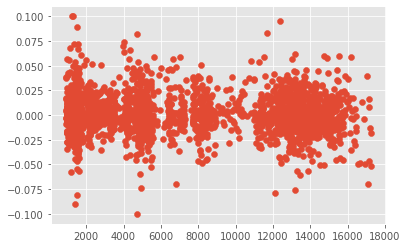

In [189]:
plt.scatter(df['vwap'], df['label'])

In [190]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Standardize each column except the 'label' column in the DataFrame
df_standardized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

df_standardized = df_standardized.drop(columns=['label'])
df_standardized['label'] = dflabel

df_standardized.dropna(inplace=True)

# get all trade dates in df_standardized, and select them in df

trade_dates = df_standardized.index
df = df.loc[trade_dates]

df_standardized

,adj_open,adj_high,adj_low,adj_close,adj_volume,HIGHLOW_PCT,PCT_Change,PCT_Change_overnight,MA5,STD5,...,psar_up_ind,sma,stc,trix,vortex_ind_diff,vortex_ind_neg,vortex_ind_pos,wma,cri,label
trade_date,,,,,,,,,,,,,,,,,,,,,
2014-11-19,-1.372569,-1.376013,-1.374215,-1.376925,0.637594,0.439055,-1.006169,-0.920261,-1.375458,-0.871861,...,-0.208156,-1.366124,1.008697,-0.098437,-0.798925,0.819365,-0.614539,-1.370570,-1.376925,-0.015614
2014-11-20,-1.375759,-1.379214,-1.376759,-1.379761,0.636085,0.256077,-0.908620,-0.870336,-1.375671,-0.857842,...,-0.208156,-1.366620,1.041623,-0.096266,-0.954144,0.956759,-0.755765,-1.371349,-1.379761,0.016260
2014-11-21,-1.378511,-1.378886,-1.377106,-1.376854,0.436848,-1.069396,0.918571,0.784023,-1.376659,-0.861910,...,-0.208156,-1.366961,1.013295,-0.094289,-0.990715,0.916037,-0.862252,-1.371616,-1.376854,0.005355
2014-11-24,-1.374573,-1.376775,-1.374947,-1.375881,0.991856,-0.484036,-0.046409,0.218025,-1.378107,-0.951142,...,-0.208156,-1.367171,1.014454,-0.091847,-0.521375,0.640708,-0.294879,-1.371673,-1.375881,0.004482
2014-11-25,-1.375119,-1.376951,-1.373987,-1.375062,0.961618,-0.986525,0.389023,0.172715,-1.378347,-0.966288,...,-0.208156,-1.367414,1.083363,-0.088611,0.045237,0.262993,0.344690,-1.371581,-1.375062,0.008471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-11,0.579253,0.569638,0.586877,0.585317,-0.774921,-0.719488,0.112945,0.015415,0.595959,-0.156145,...,-0.208156,0.634805,-0.880761,-0.094205,-0.765083,0.816817,-0.556294,0.602592,0.585317,-0.032565
2024-09-12,0.586086,0.568287,0.539611,0.515502,0.186058,2.329599,-1.964213,-1.750185,0.574256,0.491855,...,-0.208156,0.627680,-1.016859,-0.100118,-1.047855,0.847100,-1.033953,0.582987,0.515502,-0.023167
2024-09-13,0.509988,0.486899,0.480532,0.467452,0.473319,0.854441,-1.245336,-1.262405,0.545076,1.190419,...,-0.208156,0.617822,-1.084907,-0.110310,-1.649824,1.528205,-1.433153,0.557511,0.467452,-0.028548


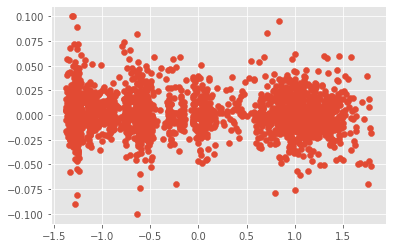

In [191]:
plt.scatter(df_standardized['vwap'], df_standardized['label'])

In [192]:
# Setting up factors and labels, X->factor and y->label

X = np.array(df_standardized.drop(columns=['label']))
y = np.array(df_standardized['label'])
print(len(X), len(y))

2394 2394


In [193]:
# Train and test data set
# Test size=0.2 means we are using 20% data as a testing data

train_test_split_idx = int(len(X) * 0.8)
X_train = X[:train_test_split_idx]
X_test = X[train_test_split_idx:]
y_train = y[:train_test_split_idx]
y_test = y[train_test_split_idx:]

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1915, 74)
y_train:  (1915,)
X_test:  (479, 74)
y_test (479,)


In [194]:
# Use Linear Regression
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(accuracy)

-0.16740097338034787


In [195]:
clf.coef_

array([ 2.22522316e-02, -6.29314564e-03, -4.62053464e-03, -1.04785376e-02,
        1.18195813e-03,  1.45320489e-03,  2.27524141e-04,  1.56370892e-04,
        8.50139968e-03, -7.00019537e-04,  3.09187956e-04,  8.04442895e-03,
       -1.30772490e-02, -2.02311539e-03,  1.01113435e-03, -7.30271560e-04,
        4.42585395e-04,  1.18876659e-03,  3.33196301e-03, -1.02215617e-03,
        1.18876659e-03,  8.19963953e-03, -1.65429754e-03,  5.14344819e-04,
        1.07692619e-03, -2.30976181e-03, -4.16632144e-03,  2.45105118e-03,
       -1.13293946e-02, -6.34984959e-02,  2.92918661e-03, -2.27709487e-01,
       -2.16876123e-01, -2.38963048e-01,  9.44364012e-04,  6.42636167e-04,
       -5.40885566e-02, -6.89120935e-03,  4.83468491e-01,  5.59827790e-01,
       -5.95654573e-04,  3.12418724e-05, -2.91709909e-03,  8.02233990e-04,
       -6.73692246e-04, -6.62717129e-04,  7.86653257e-04,  7.11667182e-04,
        4.59186365e-03, -4.05066957e-01,  3.38129216e-02, -3.30476252e-03,
        5.95318062e-03,  

In [196]:
df.loc[:, "predict"] = np.nan
df.loc[:, "predict"][:train_test_split_idx] = clf.predict(X_train)
df.loc[:, "predict"][train_test_split_idx:] = clf.predict(X_test)

df.loc[:, "predict_close"] = df["adj_close"] * (1 + df["predict"])
df.loc[:, "predict_close"] = df["predict_close"].shift(-1)

<Axes: xlabel='trade_date'>

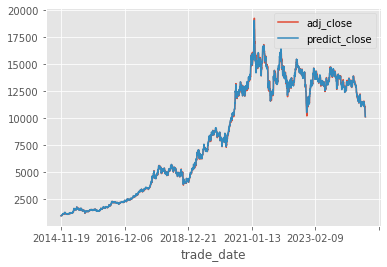

In [197]:
df[["adj_close", "predict_close"]].plot()

<Axes: xlabel='trade_date'>

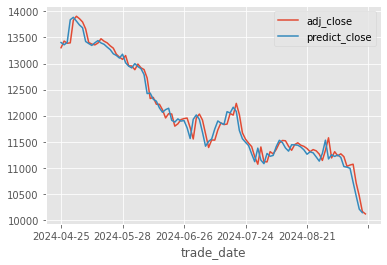

In [202]:
df[["adj_close", "predict_close"]][-100:].plot()

In [198]:
# Use Support Vector Machine. 
# clf=svm.SVR()
# clf.fit(X_train,y_train)
# accuracy=clf.score(X_test,y_test)
# print(accuracy)

# forecast_set=clf.predict(X_lately)

svr_lin = svm.SVR(kernel='linear', C=1e3).fit(X_train,y_train)
svr_poly = svm.SVR(kernel = 'poly', C=1e3, degree=2).fit(X_train,y_train)
svr_rbf = svm.SVR(kernel = 'rbf', C=1e3, gamma=0.1).fit(X_train,y_train)
accuracy_lin = svr_lin.score(X_test,y_test)
accuracy_poly = svr_poly.score(X_test,y_test)
accuracy_rbf = svr_rbf.score(X_test,y_test)
print(accuracy_lin, accuracy_poly, accuracy_rbf)

-0.001621079557883487 -0.001621079557883487 -0.001621079557883487


In [199]:
df.loc[:, "predict_svrl"] = np.nan
df.loc[:, "predict_svrl"][:train_test_split_idx] = svr_lin.predict(X_train)
df.loc[:, "predict_svrl"][train_test_split_idx:] = svr_lin.predict(X_test)
df.loc[:, "predict_close_svrl"] = df["adj_close"] * (1 + df["predict_svrl"])
df.loc[:, "predict_close_svrl"] = df["predict_close_svrl"].shift(-1)

df.loc[:, "predict_svrp"] = np.nan
df.loc[:, "predict_svrp"][:train_test_split_idx] = svr_poly.predict(X_train)
df.loc[:, "predict_svrp"][train_test_split_idx:] = svr_poly.predict(X_test)
df.loc[:, "predict_close_svrp"] = df["adj_close"] * (1 + df["predict_svrp"])
df.loc[:, "predict_close_svrp"] = df["predict_close_svrp"].shift(-1)

df.loc[:, "predict_svrr"] = np.nan
df.loc[:, "predict_svrr"][:train_test_split_idx] = svr_rbf.predict(X_train)
df.loc[:, "predict_svrr"][train_test_split_idx:] = svr_rbf.predict(X_test)
df.loc[:, "predict_close_svrr"] = df["adj_close"] * (1 + df["predict_svrr"])
df.loc[:, "predict_close_svrr"] = df["predict_close_svrr"].shift(-1)



<Axes: xlabel='trade_date'>

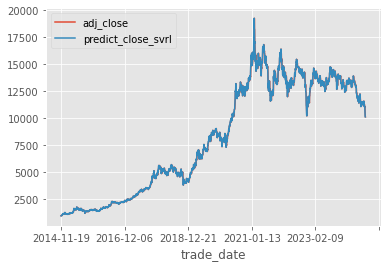

In [200]:
df[["adj_close", "predict_close_svrl"]].plot()